# Regression Hybrid Vission Transformer

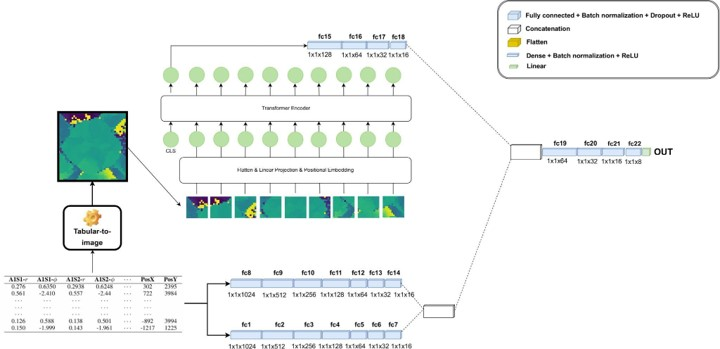

## Imports

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
#import cv2
import gc
import matplotlib.pyplot as plt
#import openslide
#from openslide.deepzoom import DeepZoomGenerator
import tifffile as tifi
import sklearn
import tensorflow as tf
import keras
import seaborn as sns
from PIL import Image


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_absolute_percentage_error

from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import vgg16, vgg19, resnet50, mobilenet, inception_resnet_v2, densenet, inception_v3, xception, nasnet, ResNet152V2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, InputLayer, LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adamax
from tensorflow.keras import layers, models, Model
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.layers import Input, Activation,MaxPooling2D, concatenate
from tensorflow.keras.utils import to_categorical
from keras import ops
from keras.utils import plot_model

from imblearn.over_sampling import RandomOverSampler

#Models of TINTOlib
from TINTOlib.tinto import TINTO
from TINTOlib.supertml import SuperTML
from TINTOlib.igtd import IGTD
from TINTOlib.refined import REFINED
from TINTOlib.barGraph import BarGraph
from TINTOlib.distanceMatrix import DistanceMatrix
from TINTOlib.combination import Combination
import TINTOlib.utils
import random 

SEED = 64
#torch.manual_seed(SEED)
#torch.cuda.manual_seed(SEED)
#torch.cuda.manual_seed_all(SEED)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

2025-04-08 15:19:17.740564: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-08 15:19:17.751426: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744118357.762630   19979 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744118357.765980   19979 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744118357.775251   19979 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Data Processing

### Read the dataset

In [2]:
dataset_name = 'cancer'

#Read CSV
df = pd.read_csv(f"../resources/Datasets/{dataset_name}.csv")
df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,45
0,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878,1.0
1,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,...,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433,1.0


In [3]:
df.shape

(568, 31)

- Extrameos cual será el tamaño cuadrático de la imagen

In [4]:
# Get the shape of the dataframe
num_columns = df.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
import math
image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

6


We delve into label encoding, a crucial preprocessing step for preparing categorical labels for use in machine learning models. Specifically for Binary classification tasks, label encoding involves transforming categorical labels into a binary format, represented by the integers 0 and 1.

In [5]:
from sklearn.preprocessing import LabelEncoder
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the last column with LabelEncoder
df.iloc[:, -1] = label_encoder.fit_transform(df.iloc[:, -1])

# Display the updated last column
print(df.iloc[:, -1])

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
563    1.0
564    1.0
565    1.0
566    1.0
567    0.0
Name: 45, Length: 568, dtype: float64


### Create images with TINTOLib

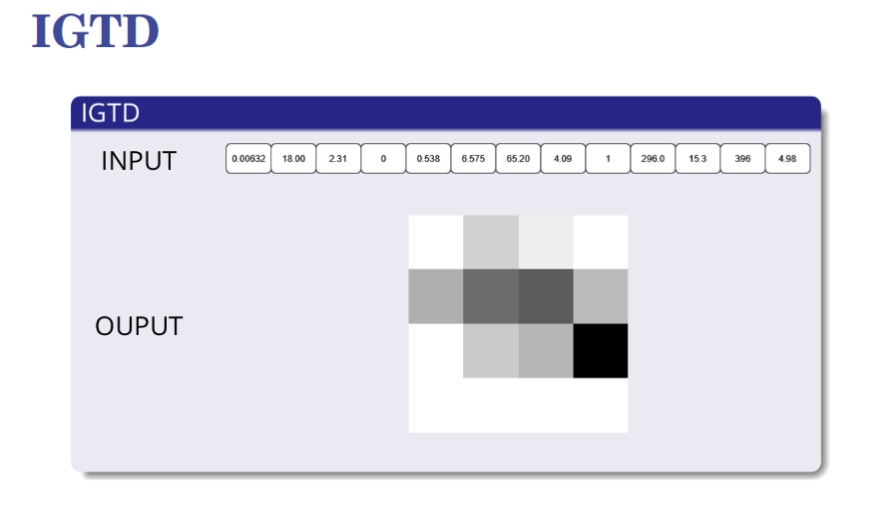

In [6]:
#Select the model and the parameters
problem_type = "supervised"
#problem_type = "regression"

# Transformation methods

image_model = IGTD(problem=problem_type, scale=[image_size,image_size], zoom=3, fea_dist_method='Euclidean', image_dist_method='Euclidean', error='abs', max_step=30000, val_step=300, random_seed=SEED)
name = f"IGTD_fEuclidean_iEuclidean_abs"

#Define the dataset path and the folder where the images will be saved
results_folder = f"Results/CNN+MLP_Fusion/{dataset_name}_{name}"
images_folder = f"Synthetic_images/images_{dataset_name}_{name}"

## Generate images

In [7]:
import cv2
from sklearn.preprocessing import MinMaxScaler

X_train, X_val = train_test_split(df, test_size=0.20, random_state=SEED)
X_val, X_test = train_test_split(X_val, test_size=0.50, random_state=SEED)

X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [8]:
def process_dataset(X, folder_name, generate_function, problem_type):
    """
    Handles dataset processing, including image generation, path updates, 
    and combining the dataset with image paths.

    Parameters:
    ----------
    X : DataFrame
        The dataset to process (training, validation, or test).
    
    folder_name : str
        The name of the folder where generated images will be stored 
        (e.g., 'train', 'val', 'test').
    
    generate_function : function
        The function used for training and generating images. It can be one of the following:
        - `fit`: Trains the model without generating images.
        - `fit_transform`: Trains the model and generates images for the dataset (used for training).
        - `transform`: Uses the pre-trained model to generate images for validation and testing.
    
    problem_type : str
        The type of problem being addressed (e.g., regression, supervised).
        This is used to locate the corresponding `.csv` file containing image paths.

    Returns:
    --------
    X_processed : DataFrame
        The dataset with updated image paths and raw tabular data, ready for further processing.
    
    y_processed : Series
        The labels corresponding to the dataset (target values).
    """
    # Generate the images if the folder does not exist
    folder_path = f"{images_folder}/{folder_name}"
    if not os.path.exists(folder_path):
        generate_function(X, folder_path)
    else:
        print(f"The images for {folder_name} are already generated")

    # Load image paths
    img_paths = os.path.join(folder_path, f"{problem_type}.csv")
    imgs = pd.read_csv(img_paths)

    # Update image paths
    imgs["images"] = folder_path + "/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, X], axis=1)

    # Split data and labels
    X_processed = combined_dataset.drop(df.columns[-1], axis=1).drop("class", axis=1)
    y_processed = combined_dataset["class"]

    return X_processed, y_processed


In [9]:
### X_train
X_train, y_train = process_dataset(X_train, "train", image_model.fit_transform, problem_type)

In [10]:
### X_val
X_val, y_val = process_dataset(X_val, "val", image_model.transform, problem_type)

In [11]:
### X_test
X_test, y_test = process_dataset(X_test, "test", image_model.transform, problem_type)

## Pre-modeling

In [12]:
#TIDY DATA SPLITTED
X_train_num = X_train.drop("images",axis=1)
X_val_num = X_val.drop("images",axis=1)
X_test_num = X_test.drop("images",axis=1)

#IMAGES
# For 3 channels (RGB)
"""X_train_img = np.array([cv2.imread(img) for img in X_train["images"]])
X_val_img = np.array([cv2.imread(img) for img in X_val["images"]])
X_test_img = np.array([cv2.imread(img) for img in X_test["images"]])"""

# For 1 channels (GRAY SCALE)
X_train_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_train["images"]])
X_val_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_val["images"]])
X_test_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_test["images"]])

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Scale numerical data
X_train_num = scaler.fit_transform(X_train_num)
X_val_num = scaler.transform(X_val_num)
X_test_num = scaler.transform(X_test_num)

attributes = X_train_num.shape[1]
## For 3-channel
#height, width, channels = X_train_img[0].shape
## For 1-chanel
height, width = X_train_img[0].shape
channels = 1
imgs_shape = (height, width, channels)

print("Images shape: ",imgs_shape)
print("Attributres: ",attributes)
pixel=X_train_img[0].shape[0]
print("Image size (pixels):", pixel)

Images shape:  (18, 18, 1)
Attributres:  30
Image size (pixels): 18


In [13]:
X_train_img[2].shape

(18, 18)

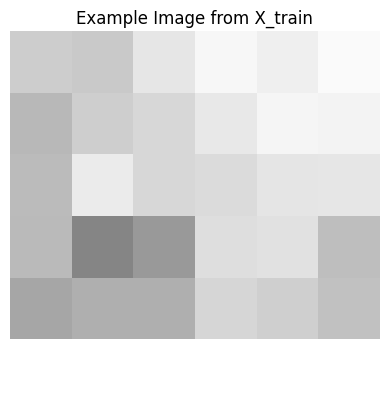

In [14]:
# Plot an example image (e.g., the first image in the array)
example_image = X_train_img[0]

# Convert the image from BGR (OpenCV default) to RGB for correct color display
example_image_rgb = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(example_image_rgb)
plt.title("Example Image from X_train")
plt.axis('off')  # Hide the axis for a cleaner look
plt.show()

## Modeling hybrid network


Now we can start the ViT+MLP training. Before that we prepare the algorithm for reading data.

In this example, 2 branch networks is created
- 1º branch: FFNN for tabular data
- 2º branch: ViT for TINTOlib images

### FFNN for tabular data

This is an example of a simple FFNN for tabular data. Note that we are not looking for the optimization of the ViT but to show an example of TINTOlib execution.

In [15]:
dropout = 0.1

In [16]:
# Single branch FFNN
ff_inputs = Input(shape = (attributes,))

mlp_1 = Dense(64, activation='relu')(ff_inputs)
mlp_1 = Dense(32, activation='relu')(mlp_1)
mlp_1 = Dense(16, activation='relu')(mlp_1)
ff_model = Model(inputs = ff_inputs, outputs = mlp_1)

I0000 00:00:1744118365.658093   19979 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


### ViT for TINTOlib images

This is an example of a simple ViT for TINTOlib images. Note that we are not looking for the optimization of the ViT but to show an example of TINTOlib execution.

It is crucial to select an appropriate patch size. The patch size should be a divisor of the input image size; for example, an image of 20x20 with a patch size of 5 would result in a total of 16 patches (4x4 grid). Given the high computational cost, the patch size should be carefully chosen based on the dimensions of the image.

This code helps identify the valid patch sizes by finding the divisors of a given number.

In [17]:
def find_divisors(n):
    divisors = []
    for i in range(1, int(n**0.5) + 1):
        if n % i == 0:
            divisors.append(i)
            if i != n // i:  # Check to include both divisors if they are not the same
                divisors.append(n // i)
    divisors.sort()
    return divisors

find_divisors(imgs_shape[1])

[1, 2, 3, 6, 9, 18]

This code defines the hyperparameters for the ViT model implemented. The hyperparameters are as follows:

- `image_size`: input image size.
- `patch_size`: size of the patches extracted from the images.
- `num_patches`: total number of patches extracted from each image.
- `projection_dim`: dimensionality of the linear projection for the patches.
- `num_heads`: number of attention heads in the transformer.
- `transformer_units`: list of units in the transformer layers.
- `transformer_layers`: number of layers in the transformer.
- `mlp_head_units`: list of units in the dense layers of the final classifier.

These hyperparameters are used to configure the ViT model and its training process.

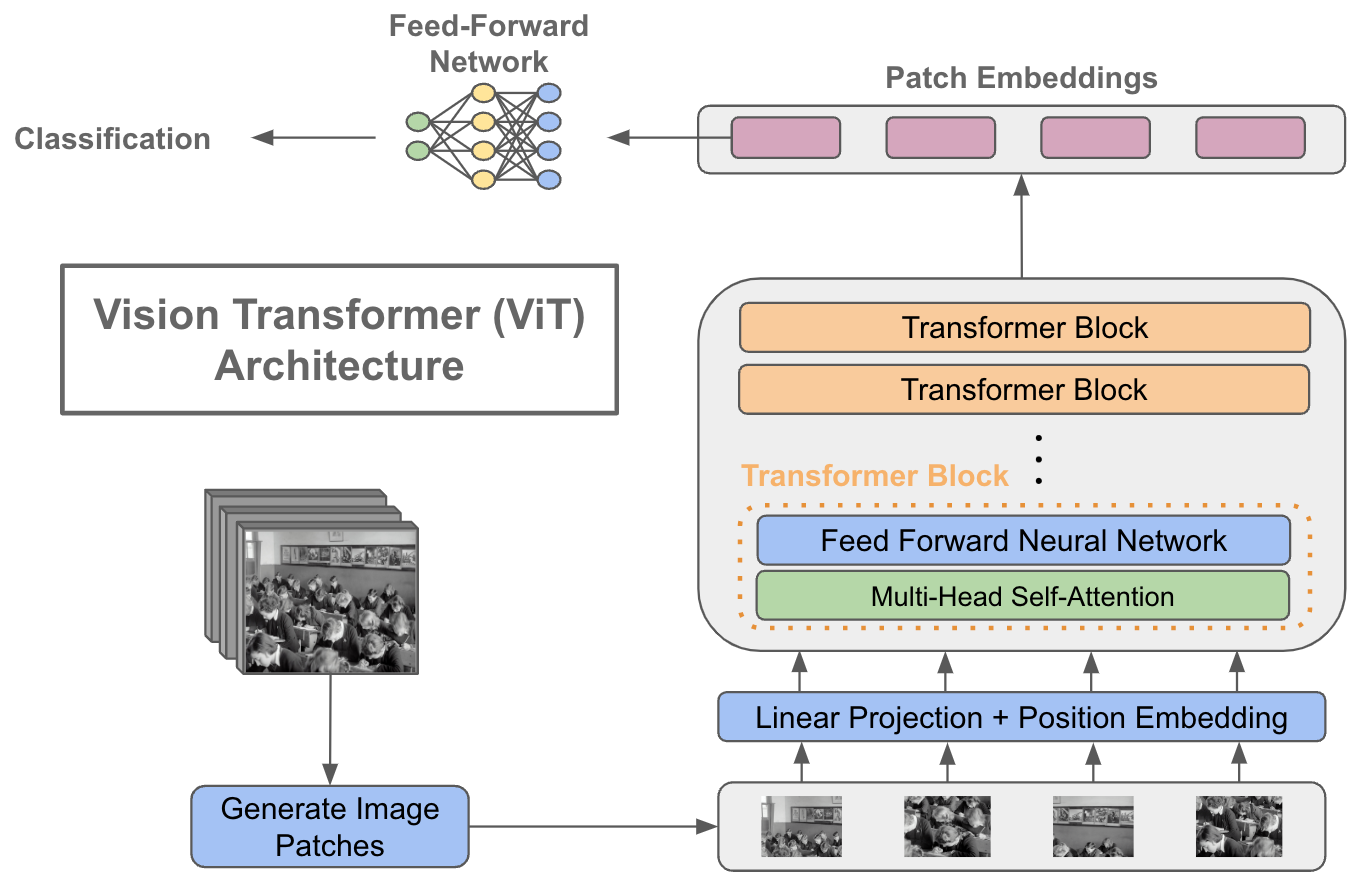

In [18]:
image_size = pixel
patch_size = 3
num_patches = (image_size // patch_size) ** 2
projection_dim = 32
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [
    128,
    64,
]

### `Patches` Class

The `Patches` class divides an image into small, fixed-size patches, rearranging them into a tensor that can be used as input for a Vision Transformer. This is essential because Transformers work with sequences, and this class converts images into sequences of patches.

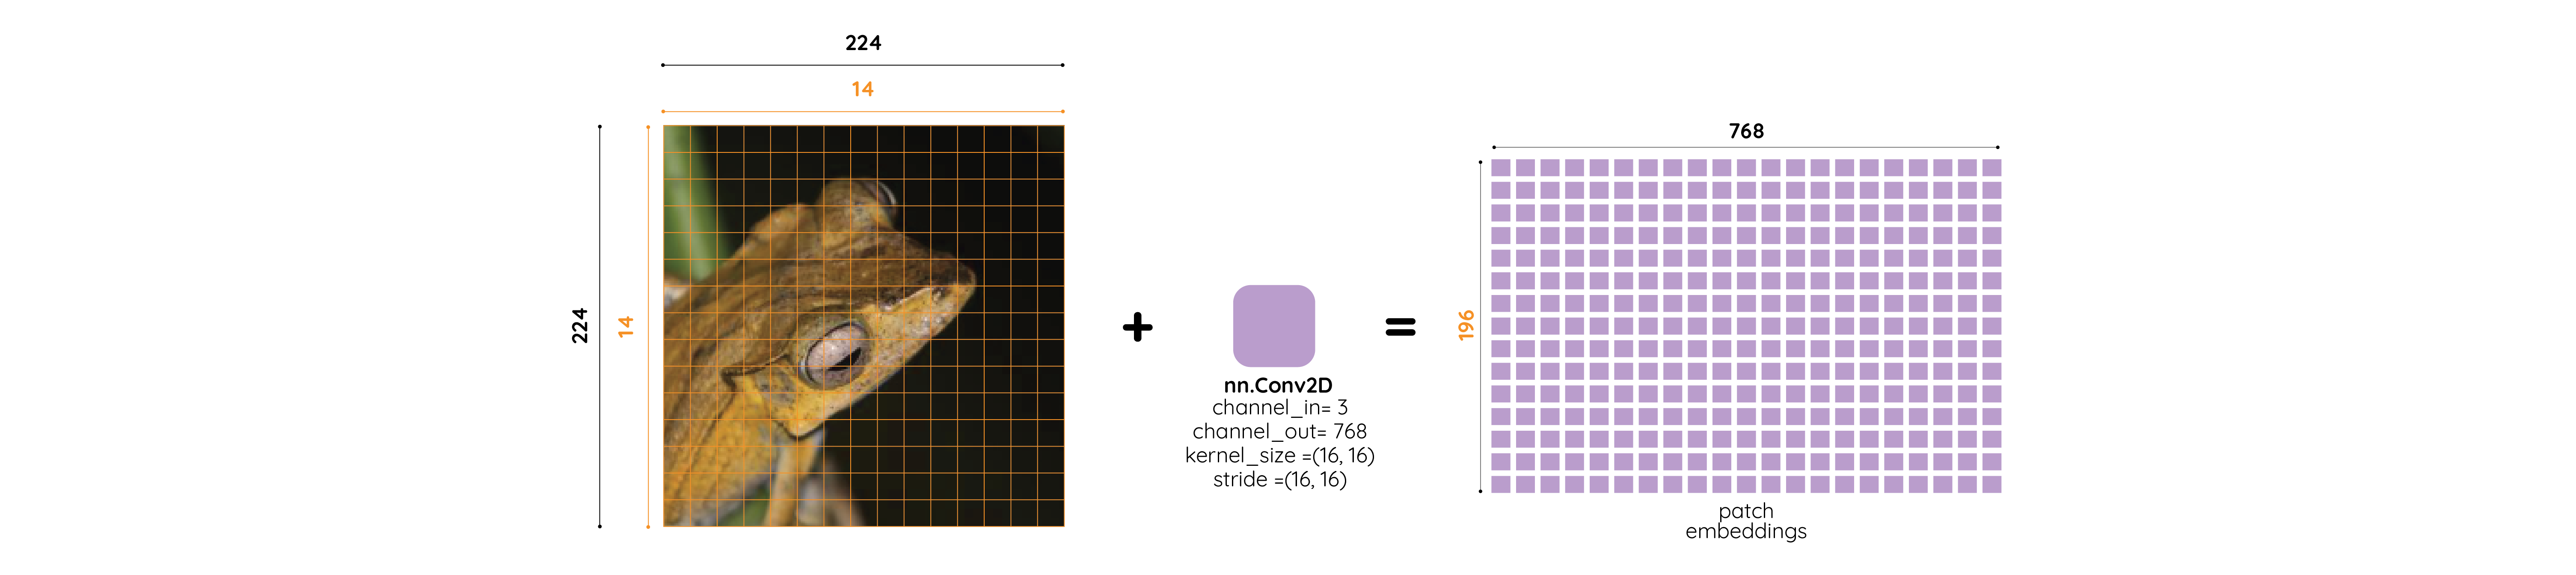

The `Patches` class is a subclass of `layers.Layer` in Keras, meaning it is a custom layer. This class is responsible for dividing an image into small patches that will be used as inputs to the Vision Transformer.

##### `__init__` Constructor
- `__init__` is the class constructor.
- `patch_size` is a parameter that specifies the size of each patch into which the image will be divided.
- `super().__init__()` calls the constructor of the base class (`layers.Layer`), initializing the layer.

##### `call` Method
- `call` is the method that defines the logic of the layer. It is invoked when a tensor (in this case, images) is passed through the layer.
- `input_shape = ops.shape(images)` retrieves the shape (dimensions) of the input tensor `images`. Assuming `images` is a 4D tensor (batch, height, width, channels).
- `batch_size`, `height`, `width`, and `channels` extract the respective dimensions of the image.
- `num_patches_h` and `num_patches_w` calculate the number of patches in the height and width of the image, respectively, by dividing the corresponding dimension by `patch_size`.
- `patches = keras.ops.image.extract_patches(images, size=self.patch_size)` uses a Keras function to extract patches of size `patch_size` from the input images.
- `patches = ops.reshape(...)` reshapes the `patches` tensor to have the shape `(batch_size, num_patches_h * num_patches_w, patch_size * patch_size * channels)`. This means that each patch is flattened and organized into a sequence of patches.

##### `get_config` Method

- `get_config` is a standard method in Keras for custom layers. It allows the layer's configuration to be saved and reloaded.
- `config = super().get_config()` calls the base class's `get_config` method to retrieve the basic configuration of the layer.
- `config.update({"patch_size": self.patch_size})` adds the `patch_size` to the configuration.
- `return config` returns the complete configuration.

In [19]:
import keras
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


### Patch Encoder

The `PatchEncoder` class takes the image patches and projects them into a higher-dimensional space using a dense layer (`Dense`). It then adds positional information to each patch using a positional embedding layer (`Embedding`). This encoding is crucial for the functioning of Transformers, which need to know both the content of the patches and their position in the original image.

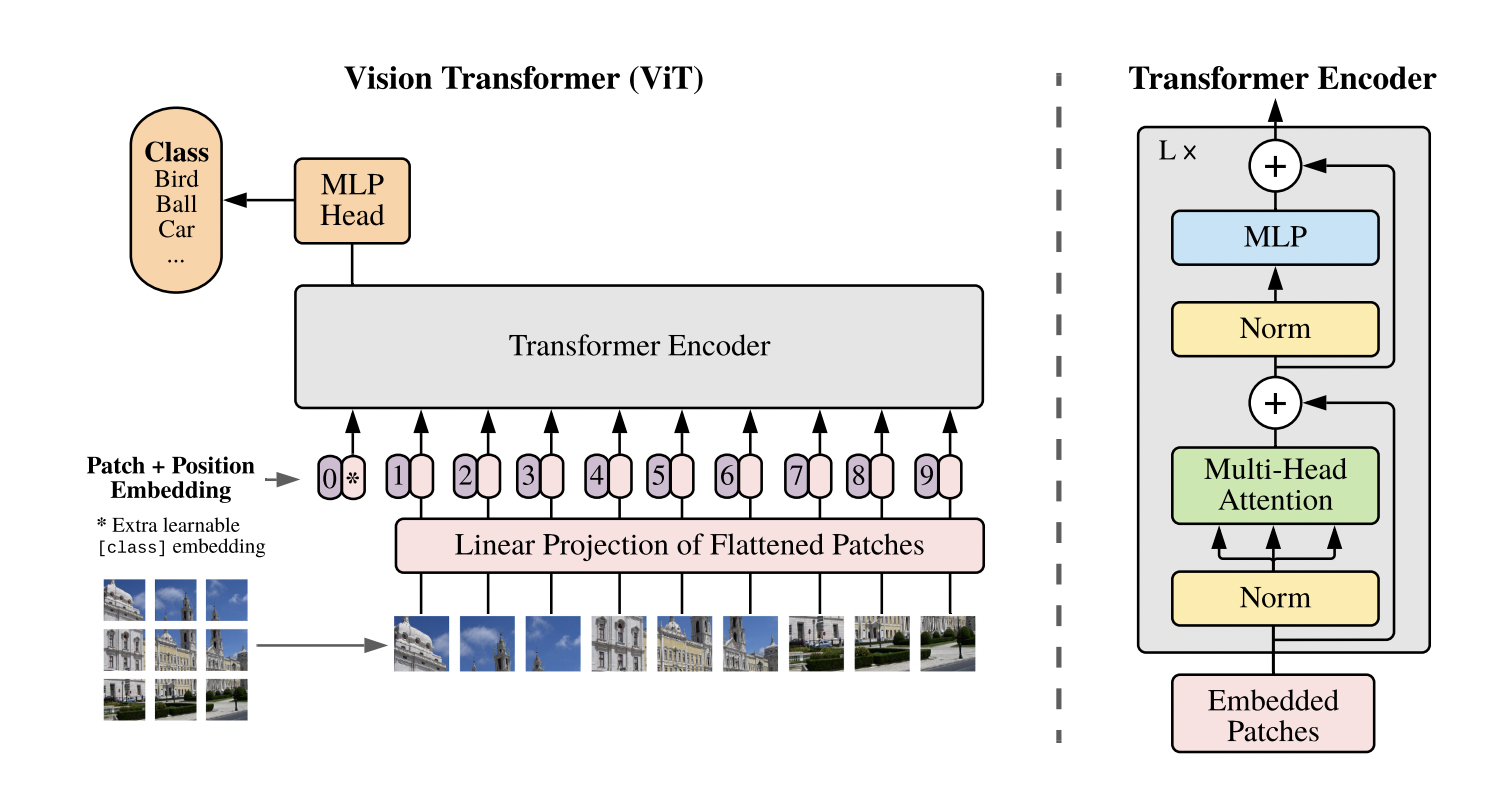

The `PatchEncoder` class is a subclass of `layers.Layer` in Keras, and it is used to project and encode the image patches.

##### `__init__` Constructor
- `__init__` is the class constructor.
- `num_patches` is the total number of patches into which the image has been divided.
- `projection_dim` is the dimension into which the patches will be projected.
- `self.projection` is a `Dense` layer that projects each patch into a higher-dimensional space specified by `projection_dim`.
- `self.position_embedding` is an `Embedding` layer that creates positional embeddings for each patch, with `num_patches` as the vocabulary size and `projection_dim` as the output dimension.

##### `call` Method
- `call` is the method that defines the logic of the layer. It is invoked when a tensor (in this case, patches) is passed through the layer.
- `positions` creates a tensor with a sequence of positions (from 0 to `num_patches - 1`), expanding the dimension to match the batch of data.
- `projected_patches` applies a linear projection to each patch using the `Dense` layer, resulting in a higher-dimensional tensor.
- `encoded` adds the linear projection of the patches (`projected_patches`) to the positional embeddings (`self.position_embedding(positions)`). This sum incorporates information about the position of each patch, which is crucial for the Transformer to understand the spatial arrangement of the patches.
- `return encoded` returns the encoded tensor.

##### `get_config` Method
- `get_config` is a standard method in Keras for custom layers. It allows the layer's configuration to be saved and reloaded.
- `config = super().get_config()` calls the base class's `get_config` method to retrieve the basic configuration of the layer.
- `config.update({"num_patches": self.num_patches})` adds `num_patches` to the configuration.
- `return config` returns the complete configuration.


In [20]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

### Classifier

The `mlp` function constructs an MLP that transforms the input tensor `x` through several dense and dropout layers. Each dense layer applies a linear transformation followed by a `gelu` activation, and each dropout layer randomly deactivates a percentage of the units from the previous layer to improve model generalization. This function is useful for adding non-linear learning capacity to the model, allowing it to capture more complex relationships in the data:
- `x`: the input tensor to be transformed.
- `hidden_units`: a list specifying the number of units (neurons) in each hidden layer of the MLP network.
- `dropout_rate`: the dropout rate applied after each dense layer, helping to prevent overfitting.


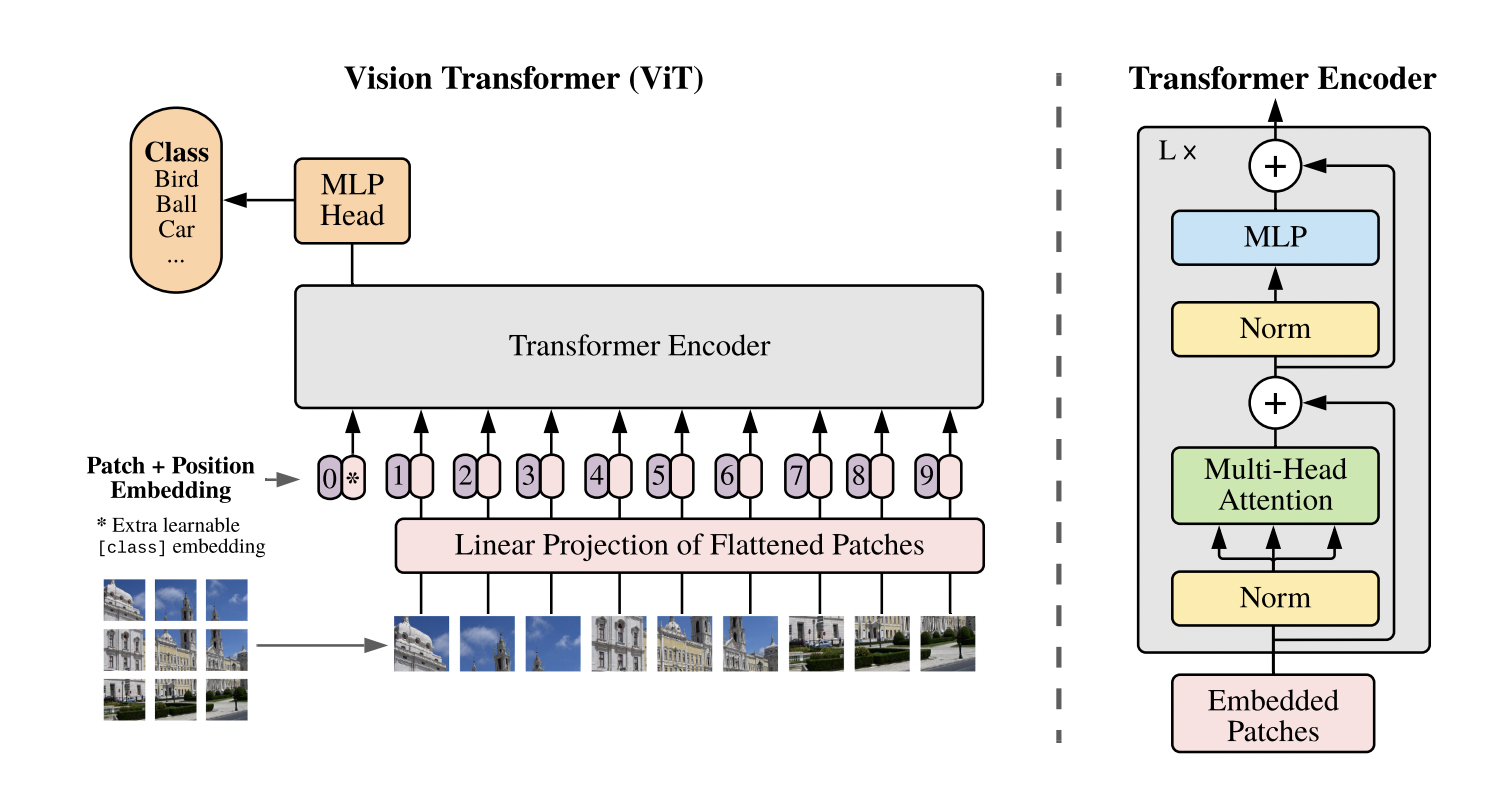

In [21]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

### ViT Classifier

The `create_vit_classifier` function constructs a complete Vision Transformer classifier.
1. It first divides the input image into patches and encodes those patches.
2. Then, it passes the encoded patches through multiple Transformer layers, each of which includes layer normalization, multi-head attention, residual connections, and MLP layers.
3. Finally, it normalizes and flattens the representation before passing it through a final MLP network to produce the output features.

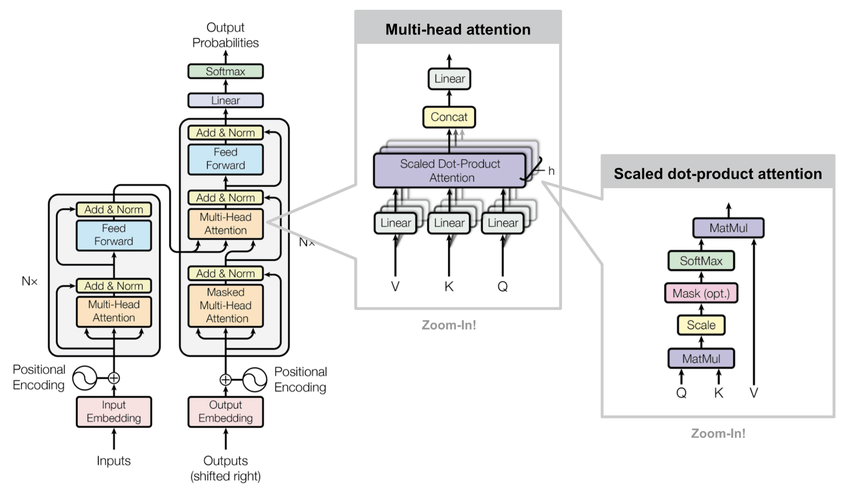

#### Model Input
- `inputs`: defines the model input with a shape specified by `input_shape`.

#### Patch Creation
- `patches`: instantiates the `Patches` layer (defined earlier) to divide the input image into smaller patches of the size specified by `patch_size`.

#### Patch Encoding
- `encoded_patches`: instantiates the `PatchEncoder` layer (defined earlier) to project the patches into a high-dimensional space and add positional embeddings.

#### Transformer Blocks
- Loops through `transformer_layers` to create multiple layers of the Transformer block.
    - `x1`: applies layer normalization to the `encoded_patches`.
    - `attention_output`: applies a multi-head attention layer.
    - `x2`: performs a residual (skip) connection by adding `attention_output` and `encoded_patches`.
    - `x3`: applies another layer normalization to `x2`.
    - `x3`: passes through an MLP using the `mlp` function defined earlier.
    - `encoded_patches`: performs another residual connection by adding `x3` and `x2`.

#### Final Representation
- `representation`: applies layer normalization, flattens the tensor, and applies dropout for regularization.

#### Final MLP Network
- `features`: applies another MLP to the final representation.


In [22]:

def create_vit_classifier():
    inputs = keras.Input(shape=imgs_shape)
    # Augment data.
    #augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=features)
    return model

In [23]:
from keras import ops
vit_model = create_vit_classifier()

## Concatenate branches

Finally, we need to fuse the ViT and MLP branches. In this case, we use a direct concatenation of the output from the ViT branch with the output from the MLP branch, feeding them into a final fully connected neural network (FFNN) that will produce the predictions.

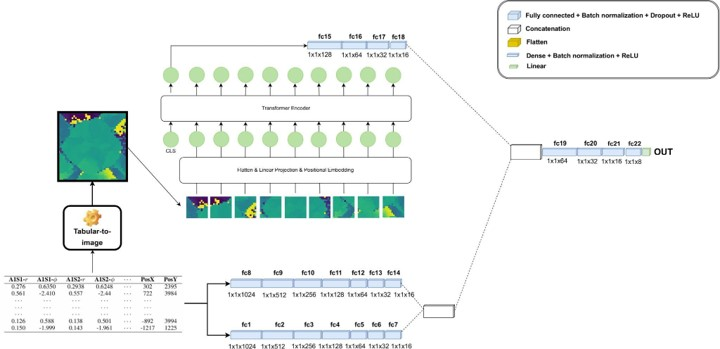

In [24]:
combinedInput = concatenate([ff_model.output, vit_model.output])
x = Dense(64, activation="relu")(combinedInput)
x = Dense(32, activation="relu")(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=[ff_model.input, vit_model.input], outputs=x)

## Metrics

Define metrics and some hyperparameters

In [25]:
METRICS = [
    #tf.keras.metrics.TruePositives(name = 'tp'),
    #tf.keras.metrics.FalsePositives(name = 'fp'),
    #tf.keras.metrics.TrueNegatives(name = 'tn'),
    #tf.keras.metrics.FalseNegatives(name = 'fn'), 
    tf.keras.metrics.BinaryAccuracy(name ='accuracy'),
    tf.keras.metrics.Precision(name = 'precision'),
    tf.keras.metrics.Recall(name = 'recall'),
    tf.keras.metrics.AUC(name = 'auc'),
]

Print the model

In [26]:
os.makedirs(results_folder, exist_ok=True)

# Redirect the summary output to the specified file
with open(results_folder+"/model_summary.txt", "w") as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

# Disable automatic matplotlib display
plt.ioff()
# Save the model plot
plot_model(model, to_file=results_folder+'model_plot.png', show_shapes=True, expand_nested=True)

# Re-enable automatic matplotlib display (optional)
plt.ion()

## Compile

Note to specify the **loss depending** on whether you have a binary or multiclass classification problem.

In [27]:
#HYPERPARAMETERS
opt = Adam(learning_rate=1e-3)

In [28]:
model.compile(
    loss="binary_crossentropy", 
    optimizer=opt,
    metrics = METRICS
)
epochs = 50

In [29]:
# Configure EarlyStopping for binary classification
early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation accuracy
    min_delta=0.001,         # Minimum change in the monitored quantity to qualify as an improvement
    patience=10,             # Number of epochs with no improvement after which training will be stopped
    verbose=1,               # Log when training stops
    mode='min',              # Maximize the accuracy; min the loss
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [30]:
model_history=model.fit(
    x=[X_train_num, X_train_img], y=y_train,
    validation_data=([X_val_num, X_val_img], y_val),
    epochs=epochs , 
    batch_size=8,
    callbacks = [early_stopper]
)

Epoch 1/50


I0000 00:00:1744118375.328917   20076 service.cc:152] XLA service 0x7f8a1c016430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744118375.328947   20076 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-04-08 15:19:35.510451: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744118376.771189   20076 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-04-08 15:19:38.564262: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_97', 4 bytes spill stores, 4 bytes spill loads

2025-04-08 15:19:38.708167: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_97', 4

14/57 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5593 - auc: 0.4042 - loss: 0.8212 - precision: 0.3719 - recall: 0.3145

I0000 00:00:1744118386.315234   20076 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5652 - auc: 0.4700 - loss: 0.7649 - precision: 0.3454 - recall: 0.2515 

2025-04-08 15:19:49.799457: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_97', 4 bytes spill stores, 4 bytes spill loads

2025-04-08 15:19:49.866761: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_97', 4 bytes spill stores, 4 bytes spill loads

2025-04-08 15:19:50.188506: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_97', 4 bytes spill stores, 4 bytes spill loads



57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 299ms/step - accuracy: 0.5633 - auc: 0.4758 - loss: 0.7604 - precision: 0.3482 - recall: 0.2569 - val_accuracy: 0.6316 - val_auc: 0.9947 - val_loss: 0.6079 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6168 - auc: 0.6249 - loss: 0.6550 - precision: 0.4523 - recall: 0.3484 - val_accuracy: 0.9298 - val_auc: 0.9947 - val_loss: 0.4549 - val_precision: 1.0000 - val_recall: 0.8095
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8296 - auc: 0.8784 - loss: 0.4302 - precision: 0.8277 - recall: 0.6458 - val_accuracy: 0.8070 - val_auc: 0.9940 - val_loss: 0.3572 - val_precision: 0.6562 - val_recall: 1.0000
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9003 - auc: 0.9601 - loss: 0.2336 - precision: 0.9002 - recall: 0.8120 - val_accuracy: 0.8421 - val_auc: 0.9987 - val_loss: 0.3240 - val_precision: 0.7000 - val_recall: 1.0000
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s

In [31]:
print(model_history.history.keys())

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall'])


## Results

Finally, we can evaluate our hybrid model with the images created by TINTOlib in any of the ways represented below.

### Train/Validation representation

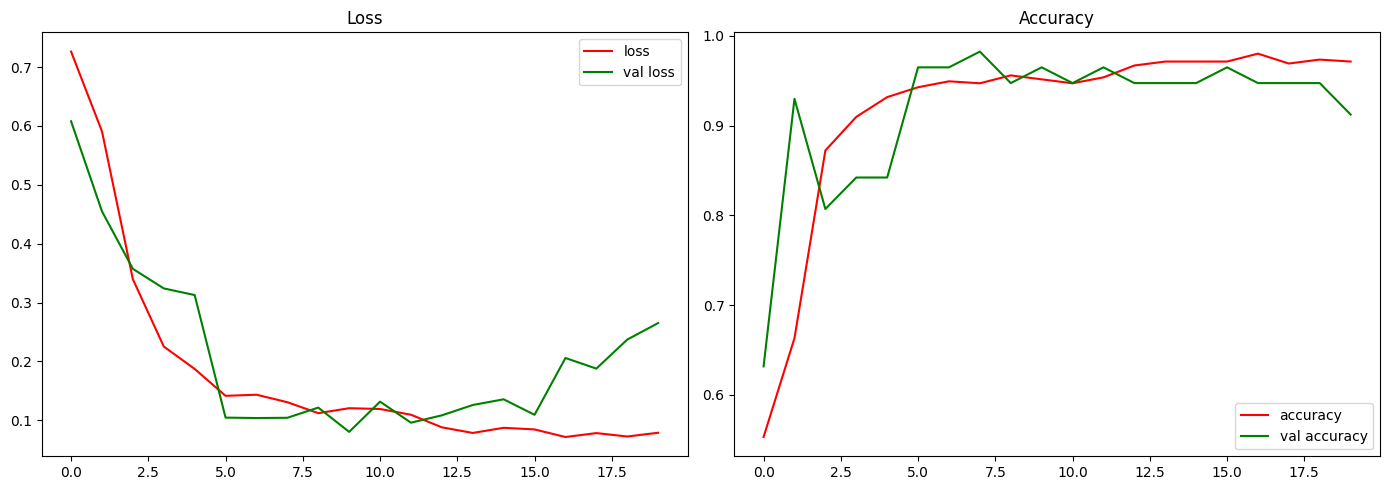

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Subplot 1: Loss
axes[0].plot(model_history.history['loss'], color='red', label='loss')
axes[0].plot(model_history.history['val_loss'], color='green', label='val loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

# Subplot 2: Accuracy
axes[1].plot(model_history.history['accuracy'], color='red', label='accuracy')
axes[1].plot(model_history.history['val_accuracy'], color='green', label='val accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

### Validation/Test evaluation

In [33]:
score_test= model.evaluate([X_test_num, X_test_img], y_test)

2025-04-08 15:20:12.403224: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_31', 4 bytes spill stores, 4 bytes spill loads

2025-04-08 15:20:12.851232: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_31', 4 bytes spill stores, 4 bytes spill loads



1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0199 - precision: 1.0000 - recall: 1.0000

2025-04-08 15:20:15.046480: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_31', 4 bytes spill stores, 4 bytes spill loads

2025-04-08 15:20:15.551558: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_31', 4 bytes spill stores, 4 bytes spill loads

2025-04-08 15:20:15.558626: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_31', 4 bytes spill stores, 4 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9883 - auc: 1.0000 - loss: 0.0284 - precision: 0.9733 - recall: 1.0000


In [34]:
prediction = model.predict([X_test_num, X_test_img])
real_values = y_test
predicted_classes = (prediction > 0.5).astype("int").reshape(-1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


In [35]:
test_accuracy = score_test[1]
test_auc = score_test[4]
test_precision = score_test[2]
test_recall = score_test[3]

print("Test accuracy:",test_accuracy)
print("Test AUC:",test_auc)
print("Test precision:",test_precision)
print("Test recall:",test_recall)

Test accuracy: 0.9824561476707458
Test AUC: 1.0
Test precision: 0.9599999785423279
Test recall: 1.0


In [36]:
train_accuracy = model_history.history["accuracy"][-1]
train_auc = model_history.history["auc"][-1]
train_precision = model_history.history["precision"][-1]
train_recall = model_history.history["recall"][-1]
train_loss = model_history.history["loss"][-1]

print("Train accuracy:",train_accuracy)
print("Train AUC:",train_auc)
print("Train precision:",train_precision)
print("Train recall:",train_recall)
print("Train loss:",train_loss)

Train accuracy: 0.9713656306266785
Train AUC: 0.9925534725189209
Train precision: 0.9636363387107849
Train recall: 0.9578313231468201
Train loss: 0.07872243225574493


In [37]:
validation_accuracy = model_history.history["val_accuracy"][-1]
validation_auc = model_history.history["val_auc"][-1]
validation_precision = model_history.history["val_precision"][-1]
validation_recall = model_history.history["val_recall"][-1]
validation_loss = model_history.history["val_loss"][-1]

print("Validation accuracy:",validation_accuracy)
print("Validation AUC:",validation_auc)
print("Validation precision:",validation_precision)
print("Validation recall:",validation_recall)
print("Validation loss:",validation_loss)

Validation accuracy: 0.9122806787490845
Validation AUC: 0.9689153432846069
Validation precision: 1.0
Validation recall: 0.761904776096344
Validation loss: 0.26509883999824524


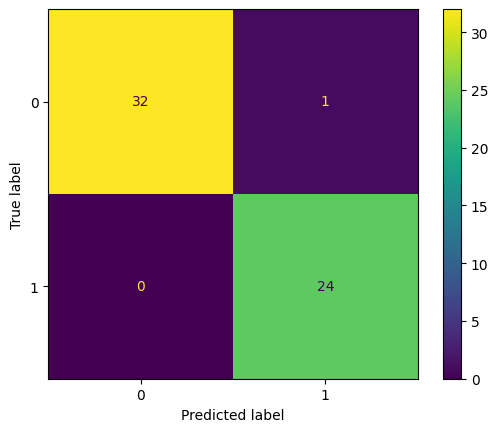

In [38]:
from sklearn.metrics import confusion_matrix
true_classes = real_values

cm = confusion_matrix(true_classes, predicted_classes)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

In [39]:
report = sklearn.metrics.classification_report(true_classes, 
                                               predicted_classes)
print(report) 

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98        33
         1.0       0.96      1.00      0.98        24

    accuracy                           0.98        57
   macro avg       0.98      0.98      0.98        57
weighted avg       0.98      0.98      0.98        57

